In [ ]:
import jax
import matplotlib.pyplot as plt
from jax import vmap

In [5]:
import jax.numpy as jnp

In [ ]:
g = lambda x, y, z: jnp.sin(x) + jnp.cos(y) + jnp.abs(z)

In [ ]:
dgdrv = vmap(jax.grad(g, argnums=(0, 1, 2)), (0, None, None), 0)


In [ ]:
xv = jnp.linspace(-10, 10, 100)

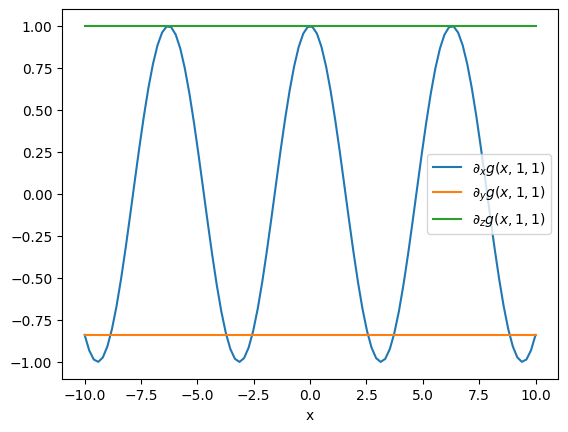

In [ ]:
dd = dgdrv(xv, 1.0, 1.0)
plt.plot(xv, dd[0], label=r"$\partial_x g(x,1,1)$")
plt.plot(xv, dd[1], label=r"$\partial_y g(x,1,1)$")
plt.plot(xv, dd[2], label=r"$\partial_z g(x,1,1)$")
plt.xlabel("x")
plt.legend()

In [ ]:
def f(x, y):
    return jnp.dot(x, y)

In [ ]:
x = jnp.linspace(0, 1, 11)
y = jnp.linspace(1, 2, 11)
f(x, y)  # → DeviceArray(9.35, dtype=float32)
jax.grad(f, argnums=0)(x, y)

Array([1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
       1.6      , 1.7      , 1.8      , 1.9000001, 2.       ],      dtype=float32)

In [ ]:
X = jnp.linspace(0, 1, 55).reshape(5, 11)
vmap(jax.grad(f, argnums=0), (0, None), 0)(X, y)  # → DeviceArray([[1. ...)

Array([[1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9000001, 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9000001, 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9000001, 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9000001, 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9000001, 2.       ]],      dtype=float32)

In [27]:
print(len(X))

5


In [ ]:
def u(x, A):
    return jnp.log(A + x)


In [31]:
from jax import grad, vmap

In [ ]:
def dARA(xarr, A):
    den = grad(grad(u, argnums=(0)), argnums=(0))
    bun = grad(u, argnums=(0))
    g = lambda x, A: -den(x, A) / bun(x, A)
    h = vmap(grad(g, argnums=(0)), (0, None), 0)
    return h(xarr, A)


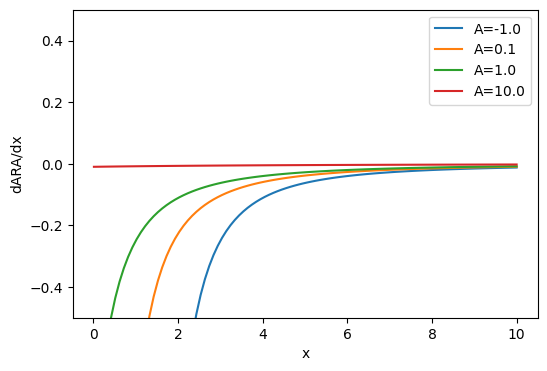

In [ ]:
Aarr = [-1.0, 0.1, 1.0, 10.0]
flg = plt.figure(figsize=(6, 4))
for A in Aarr:
    xarr = jnp.linspace(0.01, 10.0, 100)
    darr = dARA(xarr, A)
    plt.plot(xarr, darr, label=f"A={A}")
plt.xlabel("x")
plt.ylabel("dARA/dx")
plt.ylim(-0.5, 0.5)
plt.legend()

In [35]:
def scan(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, jnp.stack(ys)


In [ ]:
from jax.lax import scan

In [ ]:
def f(x, null):
    x = 1.0 / (1.0 + x)
    return x, null

In [ ]:
def g(x0):
    x, _ = scan(f, x0, None, length=3)
    return x

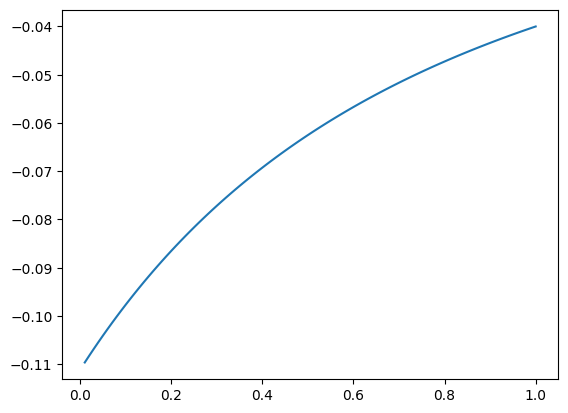

In [ ]:
from jax import jit

h = jit(vmap(grad(g)))
xarr = jnp.linspace(0.01, 1.0, 100)
darr = h(xarr)
plt.plot(xarr, darr)